In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

Data Preprocessing

In [2]:
def parse_time_to_seconds(time_str):

    if not isinstance(time_str, str):
        return None

    # find all sequences of digits in the string
    numbers = re.findall(r'\d+', time_str)

    if len(numbers) == 2:
        # Case: "a min b s" -> numbers will be ['a', 'b']
        minutes = int(numbers[0])
        seconds = int(numbers[1])
        return minutes * 60 + seconds
    elif len(numbers) == 1:
        # Case: "a min" -> numbers will be ['a']
        minutes = int(numbers[0])
        return minutes * 60
    else:
        # Handles cases where the format is unexpected or empty
        return None

def parse_percentage(perc_str):
    """Converts 'A%' string to integer."""
    if isinstance(perc_str, str):
        return int(perc_str.replace('%', ''))
    return None

def parse_speed(speed_str):
    """Converts '<num> km/h' string to integer."""
    if isinstance(speed_str, str):
        return int(speed_str.replace(' km/h', ''))
    return None

def process_traffic_data(congestion_file, speed_file, time_file, area_name):
    """Loads, cleans, and merges traffic data for a specific area (city or urban)."""

    df_congestion = pd.read_csv(congestion_file)
    df_speed = pd.read_csv(speed_file)
    df_time = pd.read_csv(time_file)

    # Melt dataframes from wide to long format to make them tidy
    df_congestion = df_congestion.melt(id_vars='Time', var_name='DayOfWeek', value_name='Congestion')
    df_speed = df_speed.melt(id_vars='Time', var_name='DayOfWeek', value_name='Speed')
    df_time = df_time.melt(id_vars='Time', var_name='DayOfWeek', value_name='TravelTime')

    # Apply the cleaning functions to each respective column
    df_congestion['Congestion'] = df_congestion['Congestion'].apply(parse_percentage)
    df_speed['Speed'] = df_speed['Speed'].apply(parse_speed)
    df_time['TravelTime'] = df_time['TravelTime'].apply(parse_time_to_seconds)

    # Merge the individual dataframes into a single comprehensive one
    df_merged = pd.merge(df_congestion, df_speed, on=['Time', 'DayOfWeek'])
    df_merged = pd.merge(df_merged, df_time, on=['Time', 'DayOfWeek'])

    # Add a column to identify the area (City or Urban)
    df_merged['Area'] = area_name

    return df_merged

In [3]:
df_city = process_traffic_data(
    '2024_week_day_congestion_city.csv',
    '2024_week_day_speed_city.csv',
    '2024_week_day_time_city.csv',
    'City')

df_urban = process_traffic_data(
    '2024_week_day_congestion_urban.csv',
    '2024_week_day_speed_urban.csv',
    '2024_week_day_time_urban.csv',
    'Urban')

df_combined = pd.concat([df_city, df_urban])

time_order = [
    "12:00 AM", "02:00 AM", "04:00 AM", "06:00 AM", "08:00 AM", "10:00 AM",
    "12:00 PM", "02:00 PM", "04:00 PM", "06:00 PM", "08:00 PM", "10:00 PM" ]
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_combined['Time'] = pd.Categorical(df_combined['Time'], categories=time_order, ordered=True)
df_combined['DayOfWeek'] = pd.Categorical(df_combined['DayOfWeek'], categories=day_order, ordered=True)

print("DataFrame head:")
print(df_combined.head())
print("\nDataFrame Info:")
df_combined.info()

DataFrame head:
       Time DayOfWeek  Congestion  Speed  TravelTime  Area
0  12:00 AM    Sunday           0     35        1031  City
1  02:00 AM    Sunday           0     37         973  City
2  04:00 AM    Sunday           0     39         930  City
3  06:00 AM    Sunday           0     36         909  City
4  08:00 AM    Sunday           0     34         979  City

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 83
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Time        168 non-null    category
 1   DayOfWeek   168 non-null    category
 2   Congestion  168 non-null    int64   
 3   Speed       168 non-null    int64   
 4   TravelTime  168 non-null    int64   
 5   Area        168 non-null    object  
dtypes: category(2), int64(3), object(1)
memory usage: 7.6+ KB


Exploratory Data Analysis

In [4]:
print("\n1. Overall Traffic Summary (City)")

with open('new_delhi_2024_city_traffic.json', 'r') as f:
    city_traffic_summary = json.load(f)

print(f"Average Travel Time per 10km: {city_traffic_summary['average_travel_time_per_10_km']}")
print(f"Average Speed: {city_traffic_summary['average_speed_km_h']} km/h")
print(f"Worst Day to Travel in 2024: {city_traffic_summary['worst_day_to_travel_2024']['date']} with an average travel time of {city_traffic_summary['worst_day_to_travel_2024']['avg_travel_time_per_10_km']}.")



1. Overall Traffic Summary (City)
Average Travel Time per 10km: 23 min 24 s
Average Speed: 25.6 km/h
Worst Day to Travel in 2024: October 25, Friday with an average travel time of 27 min 51 s.


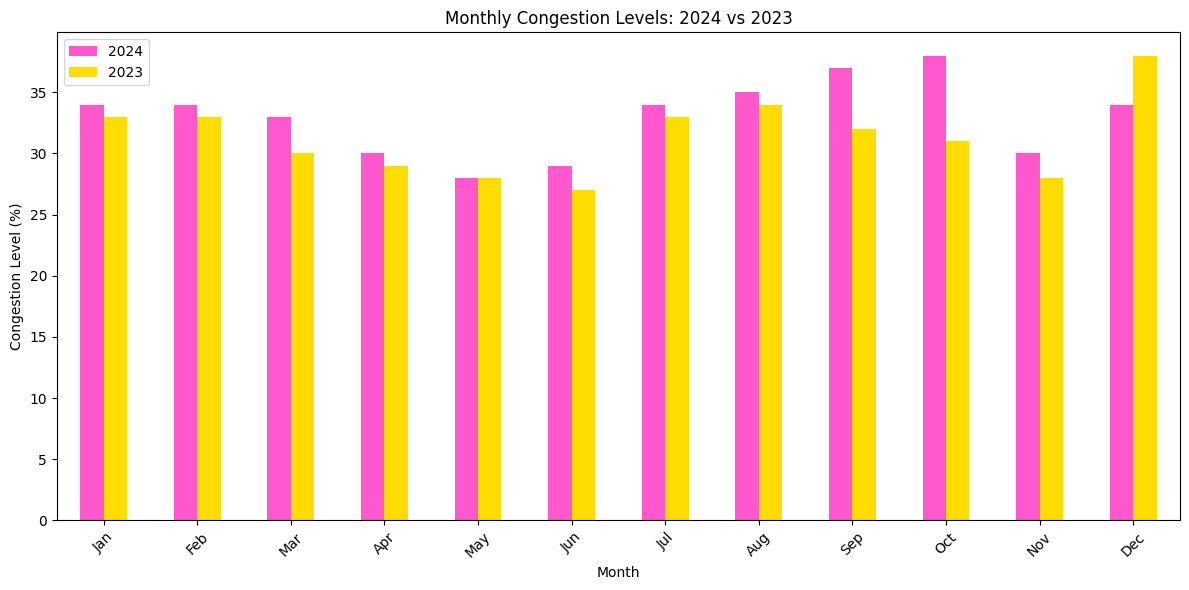

In [5]:
df_monthly = pd.DataFrame(city_traffic_summary['monthly_congestion_level'])
df_monthly.plot(x='month', y=['2024', '2023'], kind='bar', figsize=(12, 6), rot=45, color=['#FF57CD', '#FFDD03'])
plt.title('Monthly Congestion Levels: 2024 vs 2023')
plt.ylabel('Congestion Level (%)')
plt.xlabel('Month')
plt.tight_layout()
plt.savefig('monthly_congestion.png')
plt.show()

In [6]:
def plot_heatmap(df, area, metric):
    plt.figure(figsize=(10, 8))
    pivot_table = df[df['Area'] == area].pivot_table(
        values=metric,
        index='Time',
        columns='DayOfWeek',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, cmap="plasma", annot=True, fmt=".0f", linewidths=.5)
    plt.title(f'{metric} Heatmap for {area} Area')
    plt.xlabel('Day of Week')
    plt.ylabel('Time of Day')
    plt.tight_layout()
    plt.savefig(f'{area.lower()}_{metric.lower()}_heatmap.png')
    plt.show()

/tmp/ipython-input-2501503766.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df[df['Area'] == area].pivot_table(


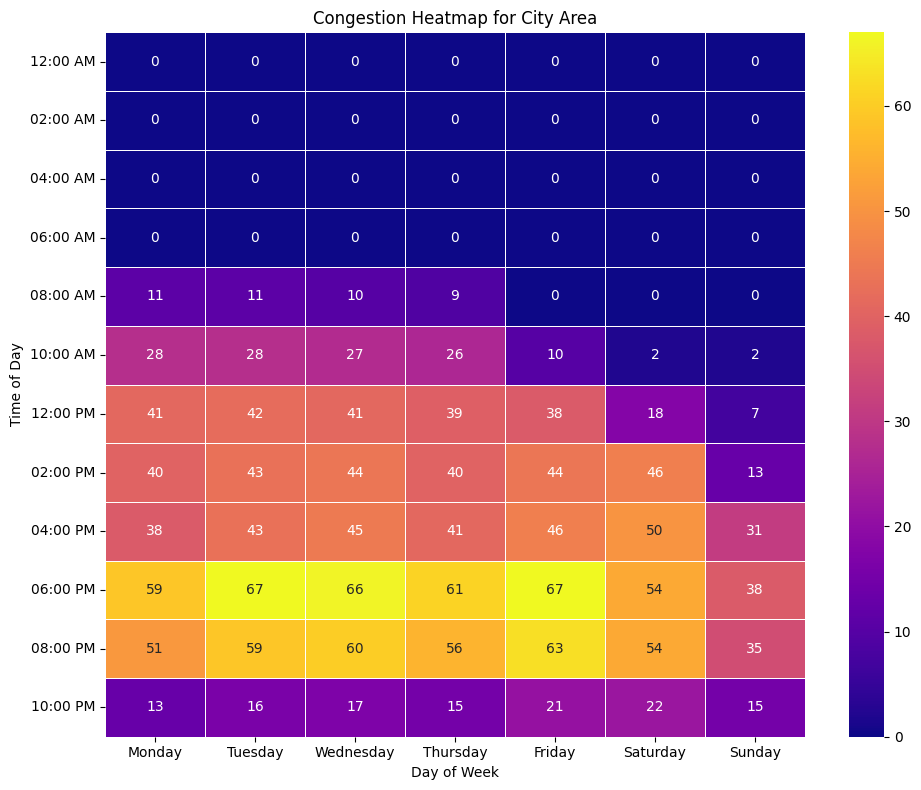

In [7]:
plot_heatmap(df_combined, 'City', 'Congestion')

/tmp/ipython-input-2501503766.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df[df['Area'] == area].pivot_table(


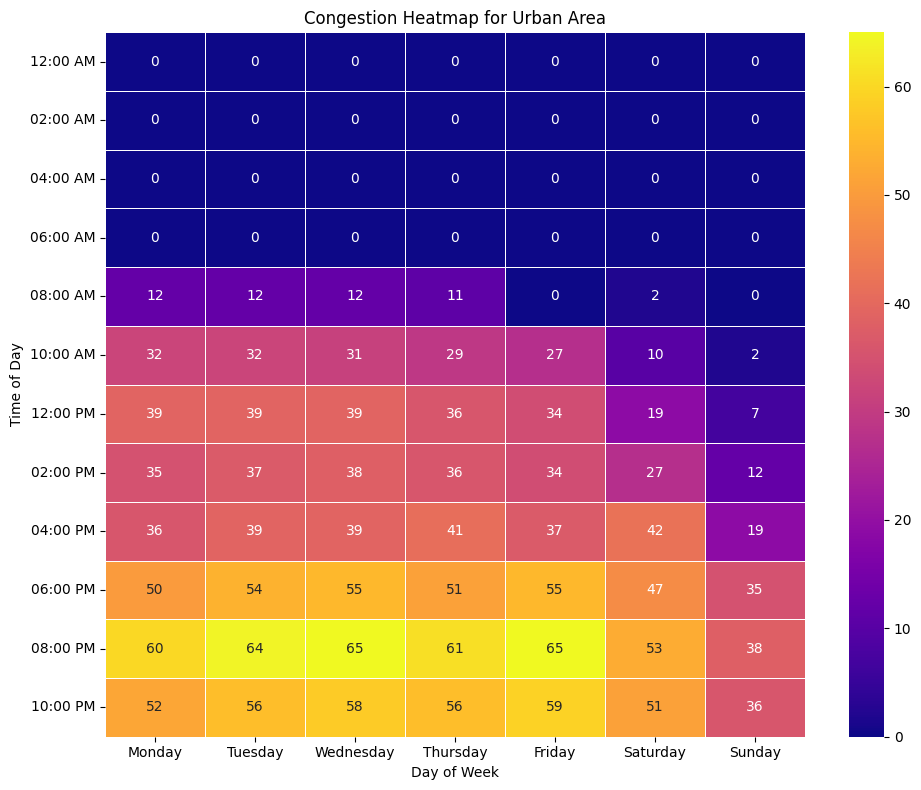

In [8]:
plot_heatmap(df_combined, 'Urban', 'Congestion')

/tmp/ipython-input-2501503766.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df[df['Area'] == area].pivot_table(


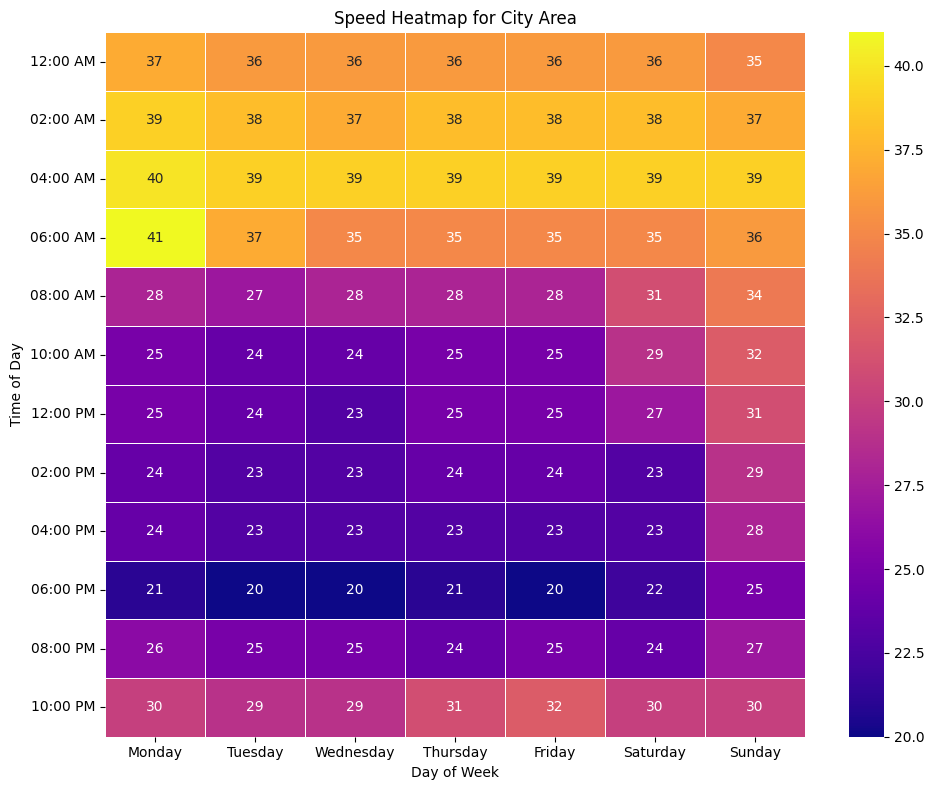

In [9]:
plot_heatmap(df_combined, 'City', 'Speed')

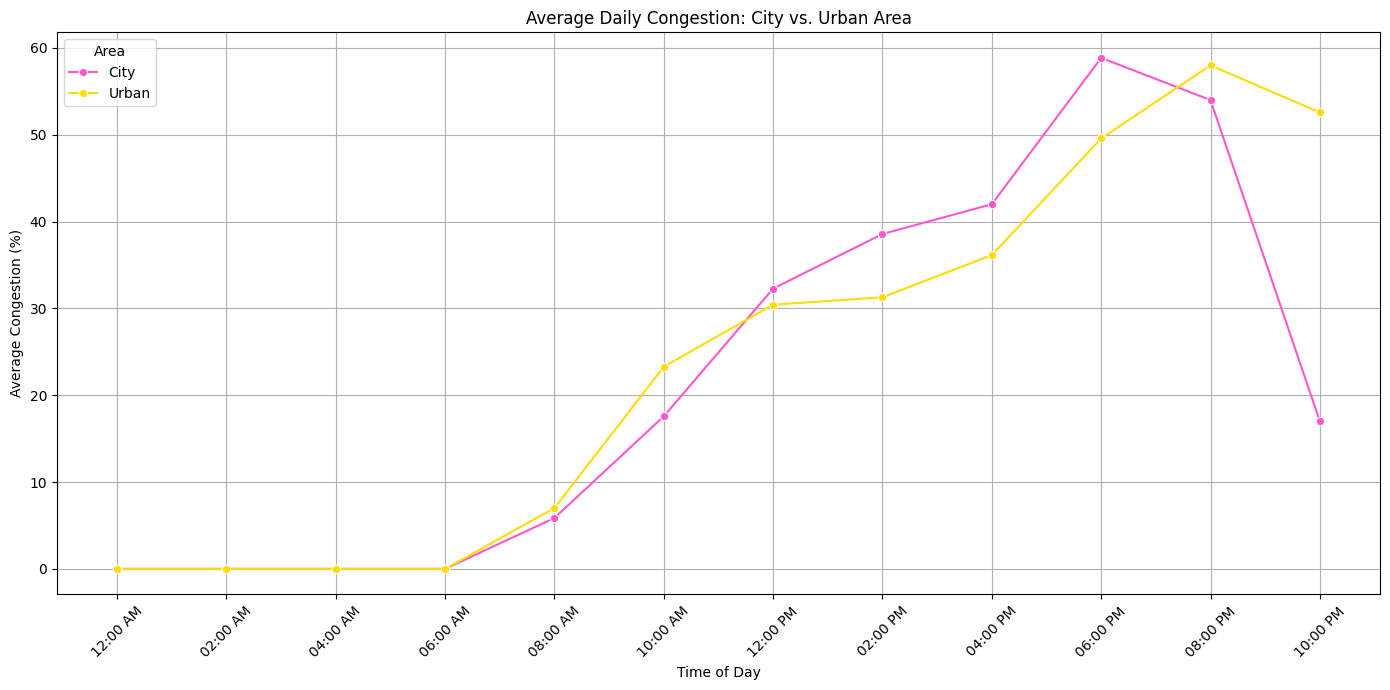

In [10]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_combined, x='Time', y='Congestion', hue='Area', marker='o', errorbar=None, palette=['#FF57CD', '#FFDD03'])
plt.title('Average Daily Congestion: City vs. Urban Area')
plt.xlabel('Time of Day')
plt.ylabel('Average Congestion (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Area')
plt.tight_layout()
plt.savefig('daily_congestion_comparison.png')
plt.show()

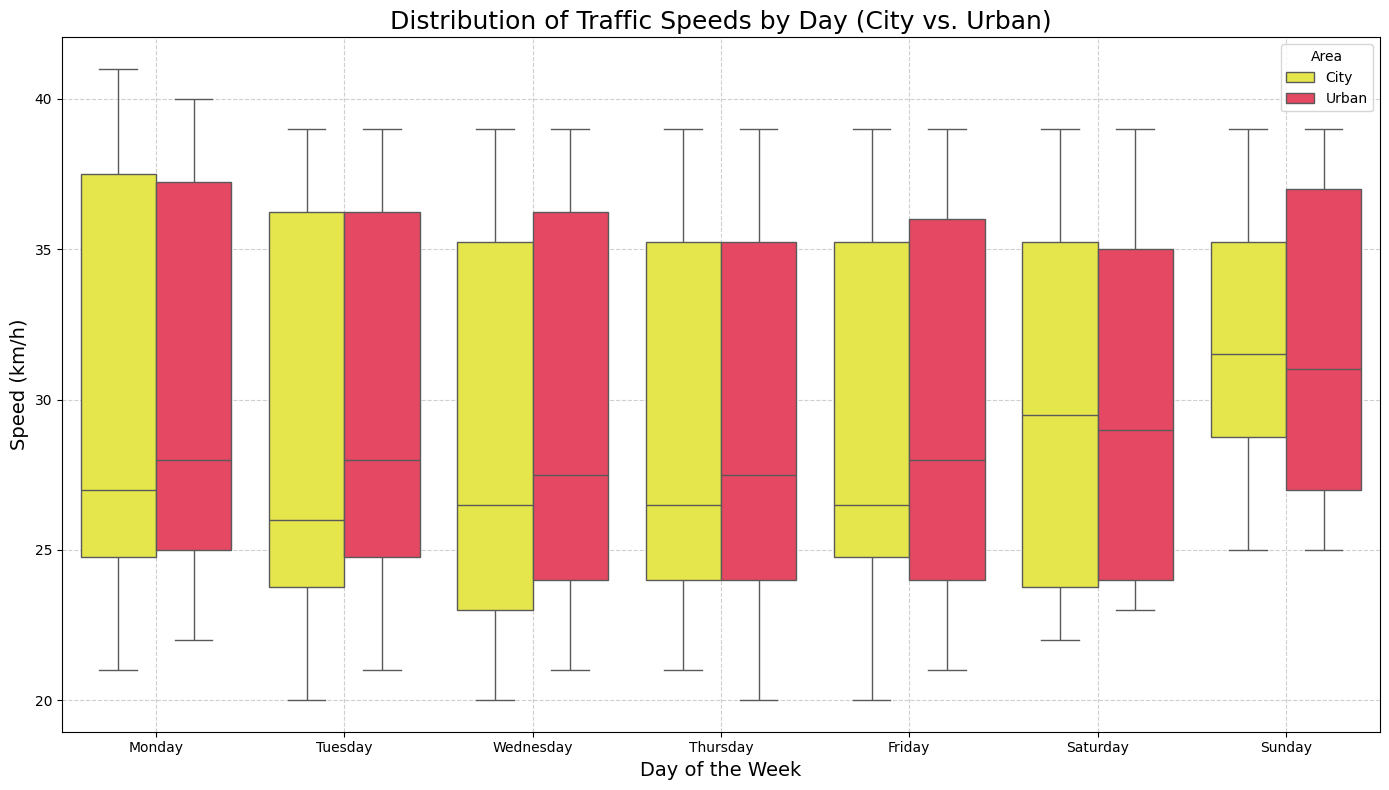

In [12]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='DayOfWeek', y='Speed', hue='Area', data=df_combined, palette=['#FEFE33','#FF2E51'])

plt.title('Distribution of Traffic Speeds by Day (City vs. Urban)', fontsize=18)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Speed (km/h)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Area')
plt.tight_layout()
plt.savefig('speed_distribution_boxplot.png')
plt.show()

In [13]:
with open('2024_city_rush_hour.json', 'r') as f:
    city_rush_hour = json.load(f)
with open('2024_urban_rush_hour.json', 'r') as f:
    urban_rush_hour = json.load(f)

print("\n--- Rush Hour Comparison ---")
print("\nCity Area:")
print(f"  Morning Rush Hour: {city_rush_hour['morning_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {city_rush_hour['morning_rush_hour']['average_speed_kmh']} km/h")
print(f"  Evening Rush Hour: {city_rush_hour['evening_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {city_rush_hour['evening_rush_hour']['average_speed_kmh']} km/h")
print(f"  Annual Extra Time in Rush Hour: {city_rush_hour['annual_extra_rush_hour_time']['total']}")

print("\nUrban Area:")
print(f"  Morning Rush Hour: {urban_rush_hour['morning_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {urban_rush_hour['morning_rush_hour']['average_speed_kmh']} km/h")
print(f"  Evening Rush Hour: {urban_rush_hour['evening_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {urban_rush_hour['evening_rush_hour']['average_speed_kmh']} km/h")
print(f"  Annual Extra Time in Rush Hour: {urban_rush_hour['annual_extra_rush_hour_time']['total']}")


--- Rush Hour Comparison ---

City Area:
  Morning Rush Hour: 43% congestion, Avg Speed: 23.6 km/h
  Evening Rush Hour: 69% congestion, Avg Speed: 19.9 km/h
  Annual Extra Time in Rush Hour: 76 hours (3 days, 4 hours)

Urban Area:
  Morning Rush Hour: 38% congestion, Avg Speed: 24.0 km/h
  Evening Rush Hour: 63% congestion, Avg Speed: 20.1 km/h
  Annual Extra Time in Rush Hour: 70 hours (2 days, 22 hours)


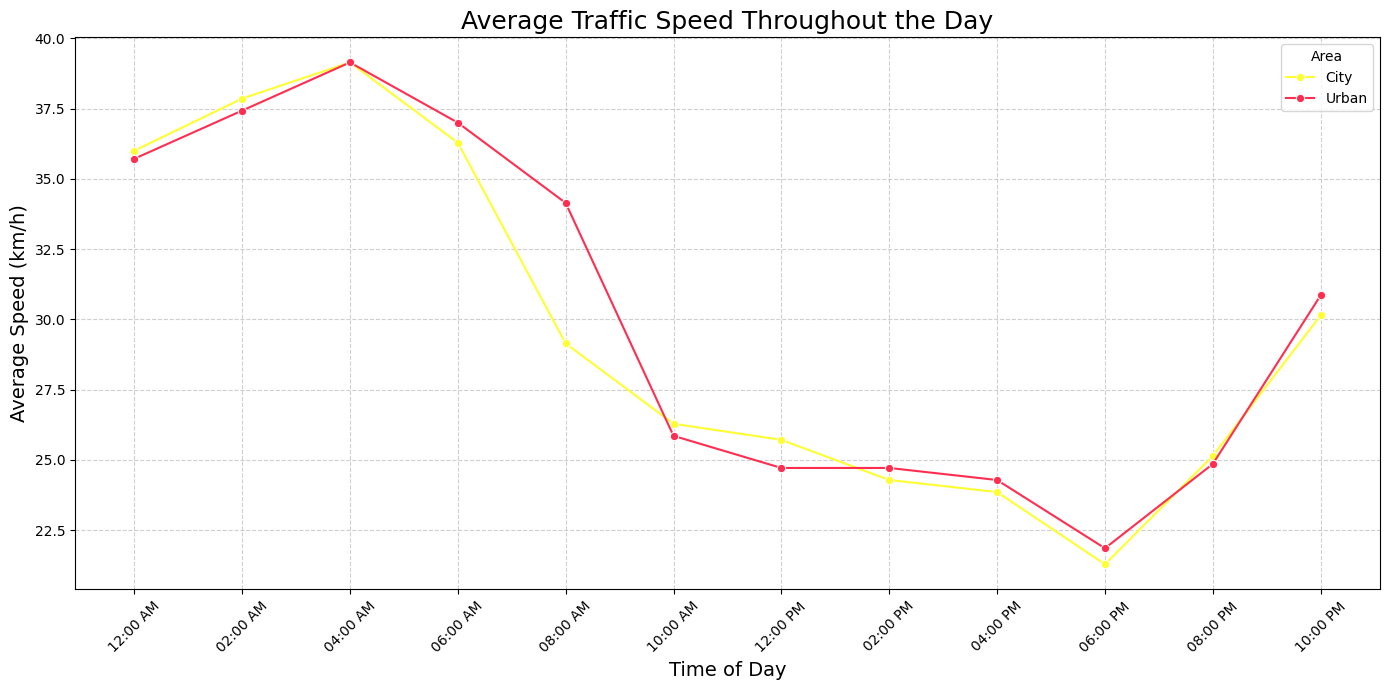

In [21]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_combined, x='Time', y='Speed', hue='Area', marker='o', errorbar=None, palette=['#FEFE33','#FF2E51'])
plt.title('Average Traffic Speed Throughout the Day', fontsize=18)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Average Speed (km/h)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Area')
plt.tight_layout()
plt.show()

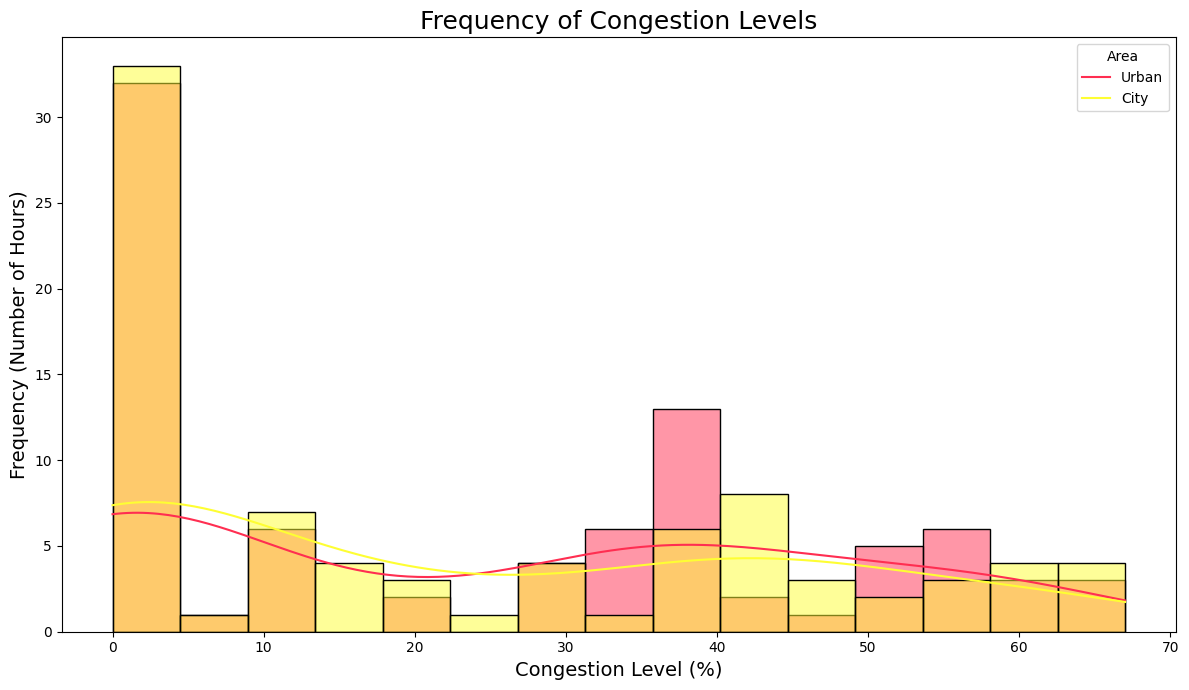

In [20]:

plt.figure(figsize=(12, 7))
sns.histplot(data=df_combined, x='Congestion', hue='Area', multiple='layer', bins=15, kde=True, palette=['#FEFE33','#FF2E51'])
plt.title('Frequency of Congestion Levels', fontsize=18)
plt.xlabel('Congestion Level (%)', fontsize=14)
plt.ylabel('Frequency (Number of Hours)', fontsize=14)
plt.legend(title='Area', labels=['Urban', 'City'])
plt.tight_layout()
plt.show()